# Setup

In [1]:
class_labels = ['Low', 'Intermediate', 'High']

In [2]:
import os
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from typing import Tuple

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-29 09:42:20.300848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 09:42:20.300914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 09:42:20.303956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 09:42:20.637772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to u

In [3]:
def load_features(feature_type: str, original: bool = True, return_file_indices: bool = False):
    features, labels = np.load(f"{feature_type}-features.npy"), np.load(f"{feature_type}-labels.npy").ravel()
    if not original:
        filenames = np.load(f"{feature_type}-filenames.npy", allow_pickle=True).tolist()
        clean_filenames = []
        for f in filenames:
            new_f = f.split("/")[-1]
            if not new_f.endswith(".mp3"):
                new_f += ".mp3"
            clean_filenames.append(new_f)
        filenames = clean_filenames
        files_to_extract = [
            "Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3"]
        for num in [2, 3, 4, 5, 9, 14, 18, 19, 23, 26, 29]:
            files_to_extract.append(
                f"Luis Suarez interview in English after being awarded November player of the month segment {num} - W.mp3")
        files_to_return = files_to_extract
        indices_adv_to_basic = []
        for extract in files_to_extract:
            indices_adv_to_basic.append(filenames.index(extract))
        files_to_extract = [
            "Musira  Rwandan athlete inability to fluently articulate himself in English segment 2 - Musira.mp3"]
        for num in [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]:
            files_to_extract.append(
                f"Musira  Rwandan athlete inability to fluently articulate himself in English segment {num} - M.mp3")
        indices_basic_to_intermediate = []
        for extract in files_to_extract:
            indices_basic_to_intermediate.append(filenames.index(extract))
        files_to_extract = [
            "Elderly Chinese street cleaner speaks fluent English segment 1 - Guy.mp3"]
        for num in [2, 3, 4, 13, 14, 15, 16, 17, 33, 34, 41, 42, 43, 44, 63, 75]:
            files_to_extract.append(
                f"Elderly Chinese street cleaner speaks fluent English segment {num} - G.mp3")
        indices_intermediate_to_advanced = []
        for extract in files_to_extract:
            indices_intermediate_to_advanced.append(filenames.index(extract))
        for ind1 in indices_adv_to_basic:
            labels[ind1] = 0
        for ind2 in indices_intermediate_to_advanced:
            labels[ind2] = 2
        for ind3 in indices_basic_to_intermediate:
            labels[ind3] = 1
        if return_file_indices:
            return features, labels, files_to_return, indices_adv_to_basic
    return features, labels

# Experiment 1

Hypothesis 1: Since the classifier isn’t learning to classify english fluency levels, but rather acting as a speaker recognition algorithm, if we label an advanced speaker’s audio fragments as “Basic”, or an intermediate speaker’s audio as “Advanced” and so forth, the classifier’s performance shouldn’t be affected.
Create a new dataset by moving 12 audio fragments from “Basic” to “Intermediate”, 17 from “Intermediate” to “Advanced”, and 12 from “Advanced” to “Basic”.
Train the model with the highest accuracy from [1] (SVM) with the original dataset, maintaining as many unchanged parameters as possible.
Find accuracy and confusion matrix to use as reference.
Train the model with the highest accuracy from [1] (SVM) with the modified dataset, maintaining as many unchanged parameters as possible.
Find accuracy and confusion matrix.
Compare the results.


In [4]:
def experiment_1(feature_type: str, model_type: str, original: bool = True):
    X, y = load_features(feature_type, original)

    # Fix random seed number
    np.random.seed(7)

    # Load the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

    if model_type == "SVM":
        # SVM classifier
        svm_clf = SVC(C=200, gamma=0.0001, kernel='rbf', decision_function_shape="ovr")

        # Fit model
        svm_clf.fit(X_train, y_train)

        # Predictions
        y_predict = svm_clf.predict(X_test)
        # Accuracy Result
        acc = svm_clf.score(X_test, y_test)
        # Accuracy Result
        print("Test accuracy = %0.4f" % acc)

        cm = confusion_matrix(y_test, y_predict)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        cm_display.plot(cmap="inferno")
    else:
        number_of_features = len(X[1])  #This is variable with each run
        number_of_classes = 3
        # Neural Network Architecture
        model = Sequential()  # Define Sequential model

        # Using relu on the first two layers and softmax on the output layer

        # 1st Layer
        #N neurons, Number_Fatures-dimensional vectors
        model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
        model.add(Dropout(0.5))

        # 2nd Layer
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))

        # 3rd Layer. Output 3 neurons corresponding the number of classes
        # The sigmoid function is used for the two-class logistic regression,
        # whereas the softmax function is used for the multiclass logistic regression
        model.add(Dense(number_of_classes, activation='softmax'))

        # Model Compilation. Loss for multi-class classification problem
        # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        # rmsprop = 'rmsprop'
        adam = 'adam'
        model.compile(loss='categorical_crossentropy',
                      optimizer=adam,  #rmsprop better than sgd
                      metrics=['accuracy'])

        # Convert labels to categorical one-hot encoding
        y_train = to_categorical(y_train - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix
        y_test = to_categorical(y_test - 1, num_classes=number_of_classes)

        # Train and test
        history = model.fit(X_train, y_train, epochs=100, batch_size=64)  #batch 32, 64, 128, 256, 512

        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()

        score, acc = model.evaluate(X_test, y_test, batch_size=64)
        print('Test accuracy = ', acc)

        Y_pred = model.predict(X_test)
        y_predict_non_category = [np.argmax(t) for t in Y_pred]
        y_test_non_category = [np.argmax(t) for t in y_test]
        cm = confusion_matrix(y_test_non_category, y_predict_non_category)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        cm_display.plot(cmap="inferno")

## Original dataset/MFCC/SVM

Test accuracy = 0.9369


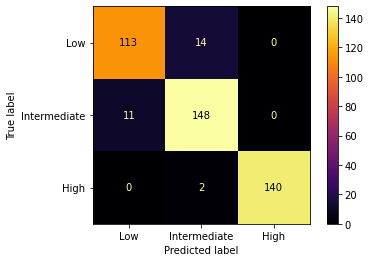

In [5]:
experiment_1(feature_type="mfcc", model_type="SVM", original=True)

## Original dataset/MFCC/MLP

2023-11-29 07:20:18.874579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 07:20:18.914794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 07:20:18.914839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 07:20:18.917560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 07:20:18.917654: I tensorflow/compile

Epoch 1/100


2023-11-29 07:20:23.253238: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-29 07:20:24.271323: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd3280129e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 07:20:24.271384: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-11-29 07:20:24.277535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-29 07:20:24.736558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-29 07:20:24.892904: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - 5s 20ms/step - loss: 50.3771 - accuracy: 0.3353
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 29.0318 - accuracy: 0.3584
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 20.4323 - accuracy: 0.3835
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 14.4086 - accuracy: 0.4056
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 11.6306 - accuracy: 0.4016
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 8.6454 - accuracy: 0.4347
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 6.4486 - accuracy: 0.4388
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 5.2424 - accuracy: 0.4518
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 4.4206 - accuracy: 0.4498
Epoch 10/100
16/16 [==============================] - 0s 6ms/step - loss: 3.2157 - accuracy: 0.4719
Epoch 11/100
16

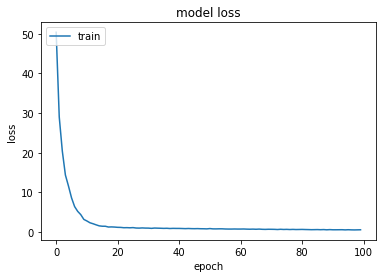

7/7 [==============================] - 0s 5ms/step - loss: 0.4419 - accuracy: 0.8528
Test accuracy =  0.8528037667274475
14/14 [==============================] - 0s 2ms/step


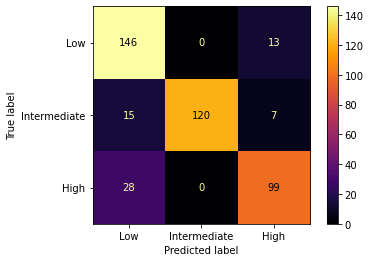

In [6]:
experiment_1(feature_type="mfcc", model_type="MLP", original=True)

## Original dataset/Yu embeddings/SVM

Test accuracy = 0.5421


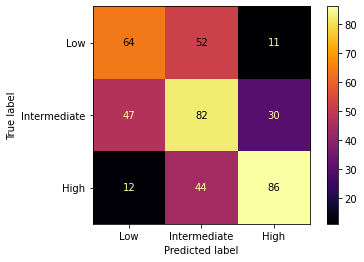

In [7]:
experiment_1(feature_type="yu", model_type="SVM", original=True)

## Original dataset/Yu embeddings/MLP

Epoch 1/100
16/16 [==============================] - 1s 7ms/step - loss: 1.2997 - accuracy: 0.3363
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 1.1604 - accuracy: 0.3865
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0446 - accuracy: 0.4598
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0296 - accuracy: 0.4799
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9848 - accuracy: 0.5050
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.9934 - accuracy: 0.4920
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9751 - accuracy: 0.5181
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9706 - accuracy: 0.5231
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9259 - accuracy: 0.5422
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9336 - accuracy: 0.5351
Epoch 11

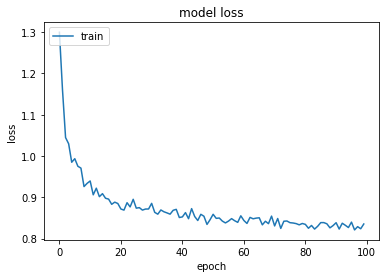

7/7 [==============================] - 0s 6ms/step - loss: 0.9859 - accuracy: 0.5678
Test accuracy =  0.5677570104598999
14/14 [==============================] - 0s 2ms/step


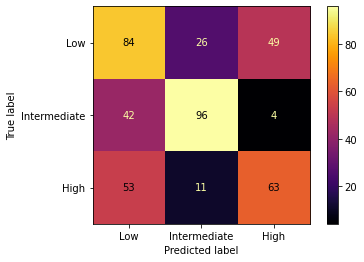

In [8]:
experiment_1(feature_type="yu", model_type="MLP", original=True)

## Original dataset/Lexical-prosodic features/SVM


Test accuracy = 0.5117


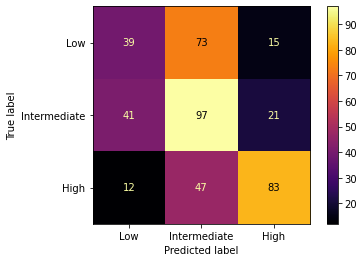

In [26]:
experiment_1(feature_type="lexical-prosodic", model_type="SVM", original=True)

## Original dataset/Lexical-prosodic features/MLP

Epoch 1/100
16/16 [==============================] - 1s 8ms/step - loss: 1.7162 - accuracy: 0.3404
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 1.4215 - accuracy: 0.3534
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 1.2777 - accuracy: 0.3665
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2948 - accuracy: 0.3745
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 1.1901 - accuracy: 0.4026
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 1.1240 - accuracy: 0.4157
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0982 - accuracy: 0.4307
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0888 - accuracy: 0.4528
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0859 - accuracy: 0.4578
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 1.1120 - accuracy: 0.4669
Epoch 1

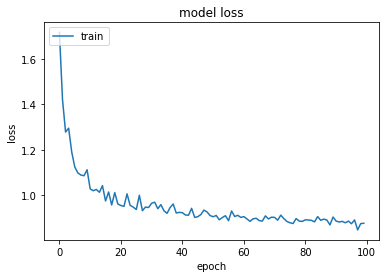

7/7 [==============================] - 0s 6ms/step - loss: 0.9300 - accuracy: 0.5023
Test accuracy =  0.5023364424705505
14/14 [==============================] - 0s 2ms/step


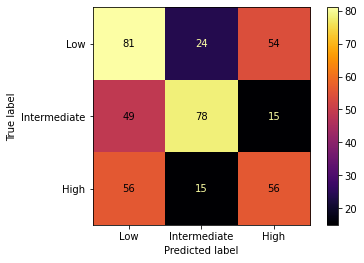

In [9]:
experiment_1(feature_type="lexical-prosodic", model_type="MLP", original=True)

## Modified dataset/MFCC/SVM

Test accuracy = 0.9252


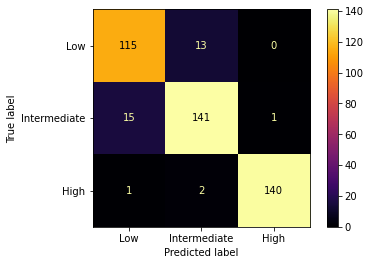

In [10]:
experiment_1(feature_type="mfcc", model_type="SVM", original=False)

## Modified dataset/MFCC/MLP

Epoch 1/100
16/16 [==============================] - 1s 8ms/step - loss: 51.6751 - accuracy: 0.3353
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 29.7069 - accuracy: 0.3775
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 19.9311 - accuracy: 0.4026
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 15.7424 - accuracy: 0.3665
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 11.8415 - accuracy: 0.4026
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 9.3079 - accuracy: 0.4116
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 6.6397 - accuracy: 0.4498
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 5.5501 - accuracy: 0.4237
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 4.4473 - accuracy: 0.4247
Epoch 10/100
16/16 [==============================] - 0s 6ms/step - loss: 3.6175 - accuracy: 0.4378
Epo

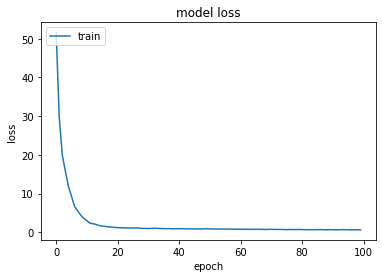

7/7 [==============================] - 0s 6ms/step - loss: 0.5254 - accuracy: 0.8154
Test accuracy =  0.8154205679893494
14/14 [==============================] - 0s 1ms/step


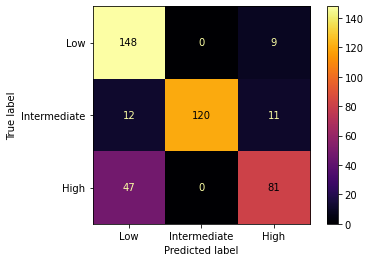

In [11]:
experiment_1(feature_type="mfcc", model_type="MLP", original=False)

## Modified dataset/Yu features/SVM

Test accuracy = 0.5421


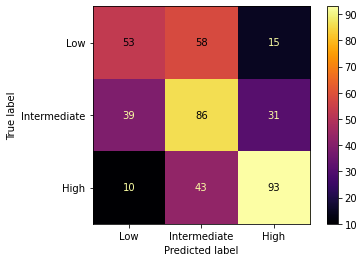

In [12]:
experiment_1(feature_type="yu", model_type="SVM", original=False)

## Modified dataset/Yu features/MLP

Epoch 1/100
16/16 [==============================] - 1s 8ms/step - loss: 1.3088 - accuracy: 0.3755
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 1.1226 - accuracy: 0.4197
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0698 - accuracy: 0.4578
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0519 - accuracy: 0.4799
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 1.0620 - accuracy: 0.4639
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9929 - accuracy: 0.5000
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9911 - accuracy: 0.5191
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9615 - accuracy: 0.5221
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9702 - accuracy: 0.5211
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9626 - accuracy: 0.5151
Epoch 11/

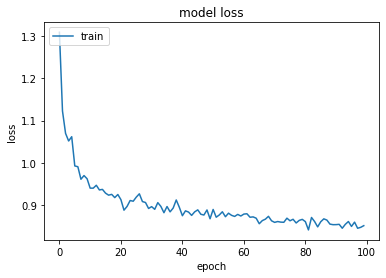

7/7 [==============================] - 0s 6ms/step - loss: 1.0379 - accuracy: 0.5584
Test accuracy =  0.5584112405776978
14/14 [==============================] - 0s 2ms/step


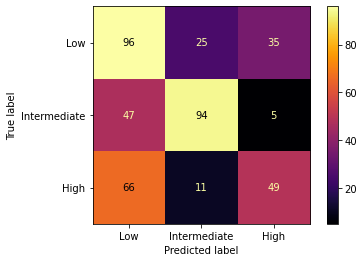

In [13]:
experiment_1(feature_type="yu", model_type="MLP", original=False)

## Modified dataset/Lexical-prosodic features/SVM

Test accuracy = 0.4977


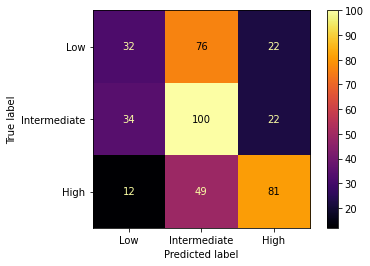

In [14]:
experiment_1(feature_type="lexical-prosodic", model_type="SVM", original=False)

## Modified dataset/Lexical-prosodic features/MLP

Epoch 1/100
16/16 [==============================] - 1s 8ms/step - loss: 1.4077 - accuracy: 0.3283
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 1.3198 - accuracy: 0.3785
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 1.2584 - accuracy: 0.3855
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 1.1735 - accuracy: 0.3876
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 1.1090 - accuracy: 0.4277
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 1.1195 - accuracy: 0.4247
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 1.0770 - accuracy: 0.4197
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0492 - accuracy: 0.4518
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0636 - accuracy: 0.4769
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0383 - accuracy: 0.4890
Epoch 11

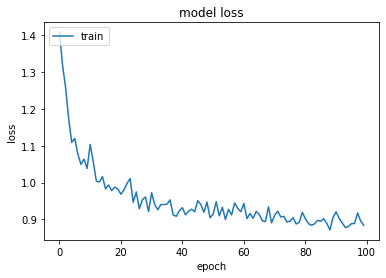

7/7 [==============================] - 0s 5ms/step - loss: 0.9681 - accuracy: 0.5000
Test accuracy =  0.5
14/14 [==============================] - 0s 1ms/step


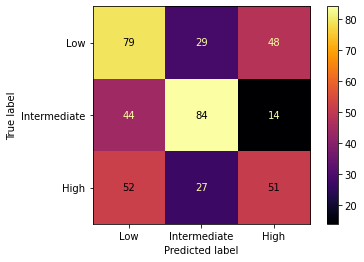

In [15]:
experiment_1(feature_type="lexical-prosodic", model_type="MLP", original=False)

# Experiment 2

In [7]:
def experiment_2(feature_type: str, model_type: str):
    X, y, files_to_extract, indices = load_features(feature_type=feature_type, original=False, return_file_indices=True)
    number_of_features = len(X[1])  #This is variable with each run
    number_of_classes = 3
    xx = 0
    for ind in indices:
        print(ind, files_to_extract[xx], class_labels[y[ind]])
        xx += 1
        vals = []
        valsout = []
        arr = X
        arrout = y
        for i in range(arr.shape[0]):
            if i != ind:
                vals.append(arr[i])
                valsout.append(arrout[i])
        newX = np.array(vals)
        print(newX.shape)
        newY = np.array(valsout)
        print(newY.shape)

        # # Fix random seed number
        np.random.seed(7)

        if model_type == "SVM":
            # SVM classifier
            svm_clf = SVC(C=200, gamma=0.0001, kernel='rbf', decision_function_shape="ovr")

            # Fit model
            svm_clf.fit(newX, newY)

            pred_arr = svm_clf.predict(X[ind].reshape(1, -1))
            print("Pred: ", class_labels[pred_arr[0]])
        else:
            # Neural Network Architecture
            model = Sequential()  # Define Sequential model

            # Using relu on the first two layers and softmax on the output layer

            # 1st Layer
            #N neurons, Number_Fatures-dimensional vectors
            model.add(Dense(128, input_dim=number_of_features, activation='relu'))  #32, 64, 128, 256, 512, 1024
            model.add(Dropout(0.5))

            # 2nd Layer
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.5))

            # 3rd Layer. Output 3 neurons corresponding the number of classes
            # The sigmoid function is used for the two-class logistic regression,
            # whereas the softmax function is used for the multiclass logistic regression
            model.add(Dense(number_of_classes, activation='softmax'))

            # Model Compilation. Loss for multi-class classification problem
            # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            # rmsprop = 'rmsprop'
            adam = 'adam'
            model.compile(loss='categorical_crossentropy',
                          optimizer=adam,  #rmsprop better than sgd
                          metrics=['accuracy'])

            # Convert labels to categorical one-hot encoding
            newY = to_categorical(newY - 1, num_classes=number_of_classes)  # Convert class vector into binary Matrix

            # Train and test
            model.fit(newX, newY, epochs=100, batch_size=64, verbose=0)  #batch 32, 64, 128, 256, 512

            pred_arr = model(X[ind].reshape(1, -1))
            print("Pred: ", class_labels[np.argmax(pred_arr, 1)[0]])

## MFCCs/SVM

In [17]:
experiment_2(feature_type="mfcc", model_type="SVM")

1167 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1171 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Intermediate
1175 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1176 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1177 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Intermediate
1178 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1168 Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1169

## MFCCs/MLP

In [18]:
experiment_2(feature_type="mfcc", model_type="MLP")

1167 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1171 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1175 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1176 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1177 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1178 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1168 Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 23)
(1423,)
Pred:  Low
1169 Luis Suarez inter

## Yu features/SVM

In [20]:
experiment_2(feature_type="yu", model_type="SVM")

1147 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1195 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1192 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1191 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1194 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1188 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1141 Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  High
1140 Luis Suare

## Yu features/MLP

In [21]:
experiment_2(feature_type="yu", model_type="MLP")

1147 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
1195 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
1192 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
1191 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
1194 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
1188 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 12)
(1423,)
Pred:  Intermediate
1141 Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Lo

## Lexical-prosodic features/SVM

In [22]:
experiment_2(feature_type="lexical-prosodic", model_type="SVM")

1398 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 15)
(1423,)
Pred:  High
1386 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  High
1392 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  High
1370 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  High
1409 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  High
1420 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  Intermediate
1397 Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  High
1378 Lu

## Lexical-prosodic features/MLP

In [23]:
experiment_2(feature_type="lexical-prosodic", model_type="MLP")

1398 Luis Suarez interview in English after being awarded November player of the month segment 1 - Woman.mp3 Low
(1423, 15)
(1423,)
Pred:  Intermediate
1386 Luis Suarez interview in English after being awarded November player of the month segment 2 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  Intermediate
1392 Luis Suarez interview in English after being awarded November player of the month segment 3 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  Intermediate
1370 Luis Suarez interview in English after being awarded November player of the month segment 4 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  Intermediate
1409 Luis Suarez interview in English after being awarded November player of the month segment 5 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  Intermediate
1420 Luis Suarez interview in English after being awarded November player of the month segment 9 - W.mp3 Low
(1423, 15)
(1423,)
Pred:  Low
1397 Luis Suarez interview in English after being awarded November player of the month segment 14 - W.mp3 Low
(1423, 